# LeNet Lab
![LeNet Architecture](lenet.png)
Source: Yan LeCun

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from __future__ import division

## Load Data

Load the MNIST data, which comes pre-loaded with TensorFlow.

You do not need to modify this section.

In [2]:
# Load pickled data
import pickle
import sys
# import cPickle
import math
plt.rcParams['image.cmap'] = 'gray'
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# TODO: fill this in based on where you saved the training and testing data
training_file = '/media/pemfir/Data/docker/lab 2 data/train2.p'
testing_file = '/media/pemfir/Data/docker/lab 2 data/test2.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
#     train = pickle.dump(pickle.load(sys.stdinf), sys.stdout, 2)
#       train = pickle.dump(f, '/docker/lab 2 data/train.p', protocol=2)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
#     test = pickle.dump(pickle.load(sys.stdin), sys.stdout, 2)


X_train, y_train = train['features'].astype('float32'), train['labels']
X_test, y_test = test['features'].astype('float32'), test['labels']

# empty image containers  
X_trainRescaled = np.empty(X_train.shape)
X_testRescaled = np.empty(X_test.shape)
# re-scaling images one by one 
for i in range(X_train.shape[0]):
    X_trainRescaled[i] = cv2.normalize(X_train[i],X_trainRescaled[i],0,1,cv2.NORM_MINMAX) 

for i in range(X_test.shape[0]):
    X_testRescaled[i] = cv2.normalize(X_test[i],X_testRescaled[i],0,1,cv2.NORM_MINMAX) 


# empty flat image containers 
X_trainFlat = np.empty([X_train.shape[0],np.prod(X_train[0].shape)])
X_testFlat = np.empty([X_test.shape[0],np.prod(X_train[0].shape)])

# flat the images 
for i,v in enumerate(X_trainRescaled):
        X_trainFlat[i] = np.reshape( v ,np.prod(v.shape))

for i,v in enumerate(X_testRescaled):
        X_testFlat[i] = np.reshape( v ,np.prod(v.shape))

        
X_train = X_trainFlat 
X_test = X_testFlat

X_validation = X_train  
y_validation = y_train

# # # y_train2 = np.eye(43)[y_train]
# # # y_test2 = np.eye(43)[y_test]
        
# # # plt.imshow(X_test2[-1])

In [3]:
labelsCount = {}
for i in y_train:
    labelsCount[i] = 0  
for i in y_train:
    labelsCount[i] += 1
m = 0 
maxValue = ''
mi = 10000 
minValue = ''
for k,v in labelsCount.items():
    if v > m:
        maxValue = (k,v)
        m = v
    if v < mi:
        minValue = (k,v)
        mi = v
print('label {0} has {1} samples'.format(maxValue[0],maxValue[1]))
print('label {0} has {1} samples'.format(minValue[0],minValue[1]))
minSampleSize = int(maxValue[1]*0.15)
print('minimum sample size is {}'.format(minSampleSize))

label 2 has 2250 samples
label 0 has 210 samples
minimum sample size is 337


In [4]:
import csv
labelsDict = {}
fh = csv.DictReader(open('/media/pemfir/Data/docker/traffic-signs/signnames.csv'))
for line in fh:
    labelsDict[int(line['ClassId'])] = line['SignName']

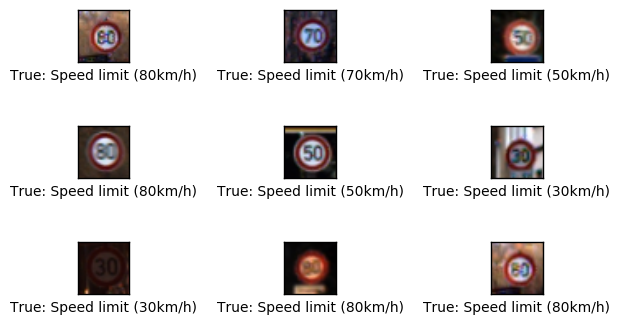

In [5]:
def plot_images(images, trueClass, predictedClass=None):
    assert len(images) == len(trueClass) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=.5, wspace=3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap='binary')

        # Show true and predicted classes.
        if predictedClass is None:
            xlabel = "True: {0}".format(labelsDict[trueClass[i]])
        else:
            xlabel = 'True:' + str(labelsDict[trueClass[i]]) + '\n' + 'red: ' + str(labelsDict[predictedClass[i]])
            #             xlabel = "True: {0},  Pred: {1}".format(labelsDict[cls_true[i]], labelsDict[cls_pred[i]])
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
    
import matplotlib.pyplot as plt
# Get the first images from the test-set.
inde = np.random.randint(0, high=10000, size=9, dtype='l')
images = X_trainRescaled[inde]

# Get the true classes for those images.
trueClass = y_train[inde]

# Plot the images and labels using our helper-function above.
plot_images(images, trueClass)

In [6]:
len(X_trainRescaled) 

39209

## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

5


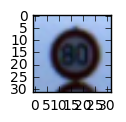

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index]
# image = b

# Reshape MNIST image from vector to matrix
image = np.reshape(image, (32,32,3))

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [8]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [9]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 100

## TODO: Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
An MNIST image is initially 784 features (1D). We reshape this to (28, 28, 1) (3D), normalize such that the values are between 0-1 instead of 0-255, and finally, pad the image with 0s, such that the height and width are 32 (centers digit further). Thus, the input shape going into the first convolutional layer is 32x32x1.

### Architecture
**Convolutional Layer 1.** The output shape should be 28x28x6.

**Activation 1.** Your choice of activation function.

**Pooling Layer 1.** The output shape should be 14x14x6.

**Convolutional Layer 2.** The output shape should be 10x10x16.

**Activation 2.** Your choice of activation function.

**Pooling Layer 2.** The output shape should be 5x5x16.

**Flatten Layer.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Fully Connected Layer 1.** This should have 120 outputs.

**Activation 3.** Your choice of activation function.

**Fully Connected Layer 2 (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [10]:
from tensorflow.contrib.layers import flatten


# [filter_size_width, filter_size_height, color_channels, k_output]
# strides=[1, strides, strides, 1] the two values are strides in x, y directions 
# out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
# out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))


def LeNet(x):
    # data enters flat but is reshaped later 
#     x = X_train[0]
    strides = 1
    # Reshape from 2D to 4D. This prepares the data for
    # convolutional and pooling layers.
    x = tf.reshape(x, (-1, 32, 32, 3))
    # Pad 0s to 32x32. Centers the digit further.
    # Add 2 rows/columns on each side for height and width dimensions.
    #     x = tf.pad(x, [[0, 0], [2, 2], [2, 2], [0, 0]], mode="CONSTANT")


    # patches of (1,5x5x1 image) x (5x5x1,6) = (1,6) do it 28x28 times so you have (28x28x6)
    # just like logistic regression, this is like you have 6 classes (5x5x1,6) matrix means
    # you have 6 neurons. Each class has its own bias for a total of 6 biases. so each convultion of a
    # small patch of image is like a mini logistic regression. 
    # at the end add a bias to each 
    # another way of looking at this is that you have 6 filters of size (5x5) you apply each filter individually 
    # after flatteining a patch of input image (1,5x5x1) to filter (5x5x1,1) and you get a single number
    # this is like what a neuron does in a logsitic regression it is connected to all features of the input vector
    # then you add a bias to it 
    # TODO: Convolution Layer 1. Input = 32x32x1. Output = 28x28x6.
    weight1 = tf.Variable(tf.truncated_normal([5,5,3,12],stddev = 0.01))   
    bias1 = tf.Variable(tf.zeros(12))
    conv1_1 = tf.nn.conv2d(x, weight1, strides=[1, strides, strides, 1], padding='VALID')
    conv1_2 = tf.nn.bias_add(conv1_1,bias1)    
    # TODO: Activation 1.
    # if we have 6 classes , then sigmoid makes sure the next layers gets values [0,1] each 
    # 28x28 vectors of length 6 add up to 1 (6 classes probabilities add to 1)
    act1 = tf.nn.sigmoid(conv1_2)
    # TODO: Pooling Layer 1. Input = 28x28x6. Output = 14x14x6.
    pool1 = tf.nn.max_pool(act1,
            ksize=[1, 2, 2, 1],
            strides=[1, 2, 2, 1],
            padding='SAME')
    # TODO: Convolution Layer 2. Output = 10x10x16.
    weight2 = tf.Variable(tf.truncated_normal([5,5,12,20],stddev = 0.01))   
    bias2 = tf.Variable(tf.zeros(20))
    conv2_1 = tf.nn.conv2d(pool1, weight2, strides=[1, strides, strides, 1], padding='VALID')
    conv2_2 = tf.nn.bias_add(conv2_1,bias2)    
    # TODO: Activation 2.
    act2 = tf.nn.sigmoid(conv2_2)
    # TODO: Pooling Layer 2. Input = 10x10x16. Output = 5x5x16.
    pool2 = tf.nn.max_pool(act2,
            ksize=[1, 2, 2, 1],
            strides=[1, 2, 2, 1],
            padding='SAME')
    # TODO: Flatten Layer.
    width = 5*5*20
    flattened = tf.reshape(pool2,[-1,width])
    # TODO: Fully Connected Layer 1. Input = 5x5x16. Output = 120.
    weight3 = tf.Variable(tf.truncated_normal([width,300],stddev = 0.01))
    bias3 = tf.Variable(tf.zeros(300))
    full1_1 = tf.matmul(flattened,weight3)
    full1_2 = tf.add(full1_1,bias3)
    full1_2 = tf.nn.dropout(full1_2, 0.75)
    # TODO: Activation 3.
    act3 = tf.nn.sigmoid(full1_2)
    # TODO: Fully Connected Layer 2. Input = 120. Output = 10.
    weight4 = tf.Variable(tf.truncated_normal([300,43],stddev = 0.01))
    bias4 = tf.Variable(tf.zeros(43))
    full2_1 = tf.matmul(act3,weight4)
    full2_2 = tf.add(full2_1,bias4)
    #     return logits
    return full2_2

In [11]:
# from tensorflow.contrib.layers import flatten


# # [filter_size_width, filter_size_height, color_channels, k_output]
# # strides=[1, strides, strides, 1] the two values are strides in x, y directions 
# # out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
# # out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))


# def LeNet(x):
#     # data enters flat but is reshaped later 
# #     x = X_train[0]
#     strides = 1
#     # Reshape from 2D to 4D. This prepares the data for
#     # convolutional and pooling layers.
#     x = tf.reshape(x, (-1, 32, 32, 3))
#     # Pad 0s to 32x32. Centers the digit further.
#     # Add 2 rows/columns on each side for height and width dimensions.
#     #     x = tf.pad(x, [[0, 0], [2, 2], [2, 2], [0, 0]], mode="CONSTANT")


#     # patches of (1,5x5x1 image) x (5x5x1,6) = (1,6) do it 28x28 times so you have (28x28x6)
#     # just like logistic regression, this is like you have 6 classes (5x5x1,6) matrix means
#     # you have 6 neurons. Each class has its own bias for a total of 6 biases. so each convultion of a
#     # small patch of image is like a mini logistic regression. 
#     # at the end add a bias to each 
#     # another way of looking at this is that you have 6 filters of size (5x5) you apply each filter individually 
#     # after flatteining a patch of input image (1,5x5x1) to filter (5x5x1,1) and you get a single number
#     # this is like what a neuron does in a logsitic regression it is connected to all features of the input vector
#     # then you add a bias to it 
#     # TODO: Convolution Layer 1. Input = 32x32x1. Output = 28x28x8.
#     weight1 = tf.Variable(tf.truncated_normal([5,5,3,8],stddev = 0.01))   
#     bias1 = tf.Variable(tf.zeros(8))
#     conv1_1 = tf.nn.conv2d(x, weight1, strides=[1, strides, strides, 1], padding='VALID')
#     conv1_2 = tf.nn.bias_add(conv1_1,bias1)    
#     # TODO: Activation 1.
#     # if we have 6 classes , then sigmoid makes sure the next layers gets values [0,1] each 
#     # 28x28 vectors of length 6 add up to 1 (6 classes probabilities add to 1)
#     act1 = tf.nn.sigmoid(conv1_2)   # 28x28x8    
#     # TODO: Pooling Layer 1. Input = 28x28x8. Output = 14x14x8.
#     pool1 = tf.nn.max_pool(act1,
#             ksize=[1, 2, 2, 1],
#             strides=[1, 2, 2, 1],
#             padding='SAME')
#     width0 = 14*14*8
#     flattened0 = tf.reshape(pool1,[-1,width0])
#     # TODO: Convolution Layer 2. Input = 14x14x8. Output = 10x10x20.
#     weight2 = tf.Variable(tf.truncated_normal([5,5,8,20],stddev = 0.01))   
#     bias2 = tf.Variable(tf.zeros(20))
#     conv2_1 = tf.nn.conv2d(pool1, weight2, strides=[1, strides, strides, 1], padding='VALID')
#     conv2_2 = tf.nn.bias_add(conv2_1,bias2)    
#     act2 = tf.nn.sigmoid(conv2_2)    
#     # TODO: Pooling Layer 2. Input = 6x6x20. Output = 3x3x10.
# #     ValueError: Dimensions must be equal, but are 8 and 20 for 
# # 'Conv2D_2' (op: 'Conv2D') with input shapes: [?,14,14,8], [6,6,20,10].
#     weight3 = tf.Variable(tf.truncated_normal([5,5,20,40]))   
#     bias3 = tf.Variable(tf.zeros(40))
#     conv3_1 = tf.nn.conv2d(act2, weight3, strides=[1, strides, strides, 1], padding='VALID')
#     conv3_2 = tf.nn.bias_add(conv3_1,bias3)        
#     # TODO: Activation 2.
#     act3 = tf.nn.sigmoid(conv3_2)
#     # TODO: Pooling Layer 2. Input = 6x6x10. Output = 3x3x40.
#     pool2 = tf.nn.max_pool(act3,
#             ksize=[1, 2, 2, 1],
#             strides=[1, 2, 2, 1],
#             padding='SAME')
#     # TODO: Flatten Layer.
#     width = 3*3*40
#     flattened = tf.reshape(pool2,[-1,width])
#     flattened_f = tf.concat(1, [flattened0, flattened])
#     # TODO: Fully Connected Layer 1. Input = 5x5x16. Output = 120.
#     weight3 = tf.Variable(tf.truncated_normal([width0+width,240],stddev = 0.01))
#     bias3 = tf.Variable(tf.zeros(240))
#     full1_1 = tf.matmul(flattened_f,weight3)
#     full1_2 = tf.add(full1_1,bias3)
#     full1_2 = tf.nn.dropout(full1_2, 0.50)
#     # TODO: Activation 3.
#     act3 = tf.nn.sigmoid(full1_2)
#     # TODO: Fully Connected Layer 2. Input = 120. Output = 10.
#     weight4 = tf.Variable(tf.truncated_normal([240,43],stddev = 0.01))
#     bias4 = tf.Variable(tf.zeros(43))
#     full2_1 = tf.matmul(act3,weight4)
#     full2_2 = tf.add(full2_1,bias4)
#     #     return logits

#     return full2_2

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

Each MNIST image is a 28x28x1 grayscale representation of a digit. So the length of an "unrolled" MNIST image vector is **784** (28x28x1=784), and the number of classes in the label set is **10**.

You do not need to modify this section.

In [12]:
x = tf.placeholder(tf.float32, (None, 32*32*3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [13]:
logits = LeNet(x)
# cross entropy of true label one_hot_y and the prediction softmax(logits) happens below
# cross entropy = -y*log(y_hat)
loss_operation = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
# optimization - minimize cross entropy 
training_operation = optimizer.minimize(loss_operation)
# finding the class with largest logit and comparing it against the true lable one_hot_y
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
# averages of 0s and 1s from the boolean operation above gives you the accuracy 
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Model Evaluation
Evaluate how well the model classifies a batch of data.

If the number of examples in the dataset is not evenly divisible by the batch size, this implementation ignores the remainder. This is fine for large datasets.

You do not need to modify this section.

In [14]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy, total_loss = 0, 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        # we want to report both the loss and accuracy so we call both operations here 
        loss, accuracy =  sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        # weighted average of accuracies by batch size gives us the total average accuracy 
        total_accuracy += (accuracy * batch_x.shape[0])
        # weighted average of losses , where the weights are size of the batches give us total loss 
        total_loss     += (loss * batch_x.shape[0])
    return total_loss / num_examples, total_accuracy / num_examples




## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            loss = sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_loss, validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Loss     = {:.3f}".format(validation_loss))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    test_loss, test_accuracy = evaluate(X_test, y_test)
    print("Test Loss     = {:.3f}".format(test_loss))
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Loss     = 3.180
Validation Accuracy = 0.170

EPOCH 2 ...
Validation Loss     = 1.432
Validation Accuracy = 0.553

EPOCH 3 ...
Validation Loss     = 0.801
Validation Accuracy = 0.770

EPOCH 4 ...
Validation Loss     = 0.501
Validation Accuracy = 0.866

EPOCH 5 ...
Validation Loss     = 0.342
Validation Accuracy = 0.914

EPOCH 6 ...
Validation Loss     = 0.243
Validation Accuracy = 0.942

EPOCH 7 ...
Validation Loss     = 0.178
Validation Accuracy = 0.962

EPOCH 8 ...
Validation Loss     = 0.145
Validation Accuracy = 0.967

EPOCH 9 ...
Validation Loss     = 0.112
Validation Accuracy = 0.975

EPOCH 10 ...
Validation Loss     = 0.097
Validation Accuracy = 0.980

Test Loss     = 0.321
Test Accuracy = 0.913
Model saved


## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [18]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_loss, test_accuracy = evaluate(X_test, y_test)
    print("Test Loss     = {:.3f}".format(test_loss))
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Loss     = 0.321
Test Accuracy = 0.911


In [38]:
def plot_confusion_matrix(classPrediction,classLabels,numClasses):
    cm = confusion_matrix(y_true=classLabels,
                          y_pred=classPrediction)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(numClasses)
    plt.xticks(tick_marks, range(numClasses))
    plt.yticks(tick_marks, range(numClasses))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.gcf().set_size_inches(18.5, 10.5)
    plt.show()

(12630,)

In [70]:
topKPredictions

array([[16,  9, 42, ..., 10,  5, 20],
       [ 1,  2,  5, ...,  8, 25, 32],
       [38, 36, 34, ..., 13, 25, 33],
       ..., 
       [ 3, 32,  6, ...,  2, 36, 38],
       [ 7,  2,  5, ..., 40, 24, 16],
       [10,  4,  9, ..., 26, 19,  8]], dtype=int32)

[[ 28  32   0 ...,   0   0   0]
 [  6 668  38 ...,   0   0   0]
 [  0  13 735 ...,   0   0   0]
 ..., 
 [  0   0   0 ...,  75   0   0]
 [  0   0   0 ...,   0  39   1]
 [  0   0   0 ...,   0   3  86]]


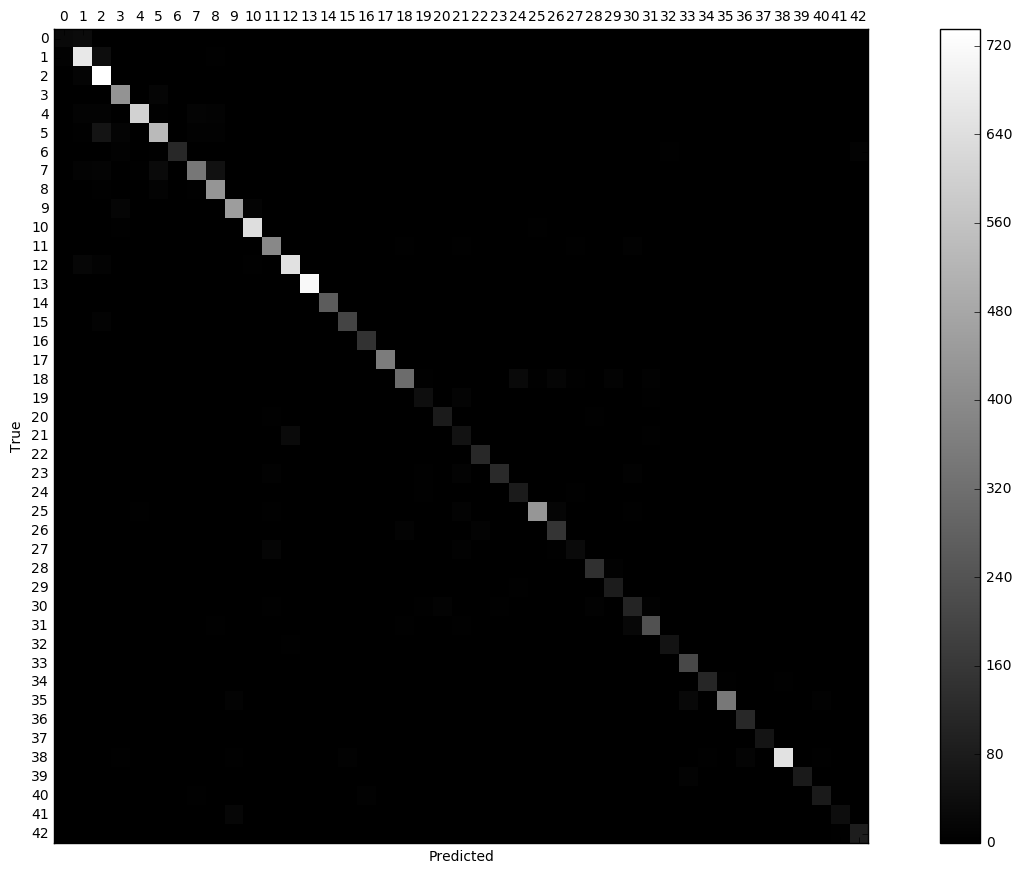

In [69]:
X_data = X_test
y_data = y_test
samplePrediction = tf.argmax(logits, 1)
_,topKPrediction = tf.nn.top_k(logits, 10)
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    predicedClass,topKPredictions =  sess.run([samplePrediction,topKPrediction], feed_dict={x: X_data, y: y_data})
plot_confusion_matrix(predicedClass,y_test,numClasses = 43)

In [ ]:

ax.set_xticks
fig.

In [ ]:
y_test[1]

In [ ]:

def print_test_accuracy(show_example_errors=False,show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(y_test)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    predictedClass = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.
    y_pred = tf.nn.softmax(full2_2)
    yPredictedClass = tf.argmax(y_pred, dimension=1)
    correct_prediction = tf.equal(yPredictedClass, yTrueClass)
    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = X_test[i:j, :]

        # Get the associated labels.
        labels = y_test[i:j,:]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,y_true: labels}

        # Calculate the predicted class using TensorFlow.
        predictedClass[i:j] = session.run(yPredictedClass, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    print('y_test',y_test.shape, y_test)
    print('cls_pred',cls_pred.shape, cls_pred)
    cls_true = y_test

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    print(correct)
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
        
print_test_accuracy(show_example_errors=True,show_confusion_matrix=True)